<a href="https://colab.research.google.com/github/yagohilario1992/Data_Science/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/yagohilario1992/Data_Science/main/Yago%20Hil%C3%A1rio%20Andrade.png">

#### [**Yago Hilário Andrade**](https://www.linkedin.com/in/yago-hilario/)

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

# Pacotes e Bibliotecas.

Para que possamos discorrer nossas analises iremos importar diversos pacotes e bibliotecas que nos ajudaram no decorrer do projeto.  

In [1]:
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [2]:
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Variáveis

* SeniorCitizen = Idoso
* Partner = Casado
* Dependents = Dependentes
* tenure = Tempo de uso dos serviços
* PhoneService = Serviço de telefone
* MultipleLines = Multiplas linhas
* InternetService = Tipo de Internet
* OnlineSecurity = Seguro Online
* OnlineBackup = Backup Online
* DeviceProtection = Dispositivo de segurança
* TechSupport = Suporte técnico
* StreamingTV = TV streaming
* StreamingMovies = Filmes streaming
* Contract = Tipo de contrato
* PaperlessBilling = Cobrança sem papel
* PaymentMethod = Método de pagamento
* MonthlyCharges = Mensalidade
* TotalCharges = Custos Totais
* Churn = Cancelamento


Ultilizando o método `dtypes` podemos observar os tipos de entradas do *dataset*

In [3]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
df.shape

(7043, 21)

O *dataset* é dotado de 21 colunas e 7043 linhas

Verificando valores ausentes.

In [5]:
((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)

Churn               0.0
OnlineSecurity      0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineBackup        0.0
TotalCharges        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
customerID          0.0
dtype: float64

Acima notamos que não exitem valores faltantes, por se tratar de um *dataset* com sua maioria de variáveis categoricas vamos abaixo observar suas entradas e suas divisões, também faremos uso de gráficos de barras para uma melhor vizualisação.

In [6]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

A coluna "TotalCharges" se apresenta como um valor, no entanto quando observamos df.dtypes podemos notar que se trata de um objeto, a diante vamos converter-lo em um numero decimal.

In [7]:
#df["TotalCharges"].astype('float32')

como resultado foi nos retornado um erro, onde diz haver texto e por isso não é possível fazer a tranformação. com isso vamos tentar um outra abordagem.

In [8]:
def convert_str_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan

df_clean = df.copy()
df_clean.drop('customerID', axis=1, inplace=True)
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(convert_str_float)

Aproveitando foi removido a lable customerID visto que ela não é relevante para nossa analise.

In [9]:
print(f"Dados ausentes antes {df_clean['TotalCharges'].isnull().sum()}")

Dados ausentes antes 11


Descobrimos que há 11 valores ausentes na lable trabalhada, por se tratar de um número infimo podemos inferir valores, estes serão a propria mediana da coluna.

In [10]:
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64


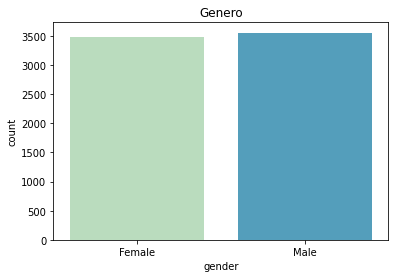

In [11]:
print(df.gender.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('gender', data=df, ax=ax, palette="GnBu")
ax.set_title('Genero')

plt.show()

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64


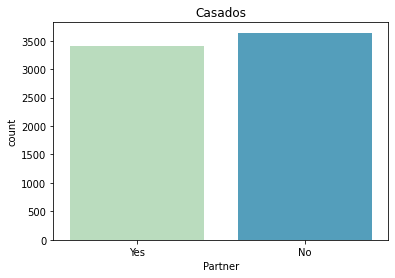

In [12]:
print(df.Partner.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('Partner', data=df, ax=ax, palette="GnBu")
ax.set_title('Casados')

plt.show()



No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64


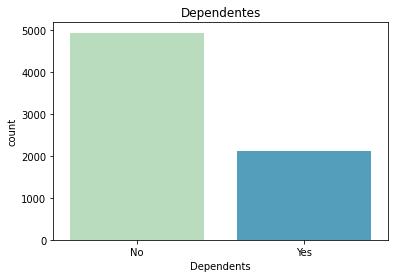

In [13]:
print(df.Dependents.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('Dependents', data=df, ax=ax, palette="GnBu")
ax.set_title('Dependentes')

plt.show()

Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64


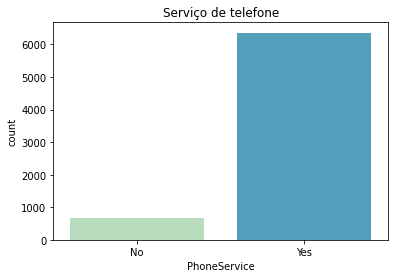

In [14]:
print(df.PhoneService.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('PhoneService', data=df, ax=ax, palette="GnBu")
ax.set_title('Serviço de telefone')

plt.show()

No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64


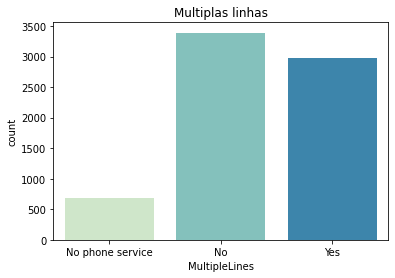

In [15]:
print(df.MultipleLines.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('MultipleLines', data=df, ax=ax, palette="GnBu")
ax.set_title('Multiplas linhas')

plt.show()

Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64


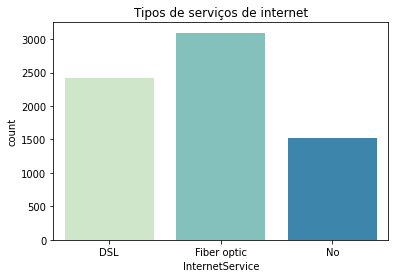

In [16]:
print(df.InternetService.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('InternetService', data=df, ax=ax, palette="GnBu")
ax.set_title('Tipos de serviços de internet')

plt.show()

No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64


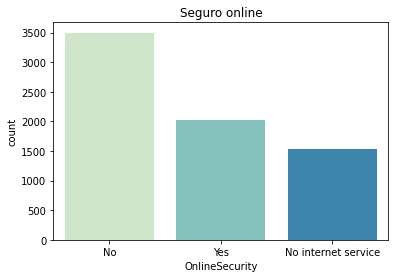

In [17]:
print(df.OnlineSecurity.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('OnlineSecurity', data=df, ax=ax, palette="GnBu")
ax.set_title('Seguro online')

plt.show()

No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: OnlineBackup, dtype: float64


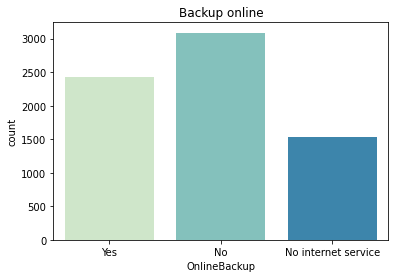

In [18]:
print(df.OnlineBackup.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('OnlineBackup', data=df, ax=ax, palette="GnBu")
ax.set_title('Backup online')

plt.show()

No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: DeviceProtection, dtype: float64


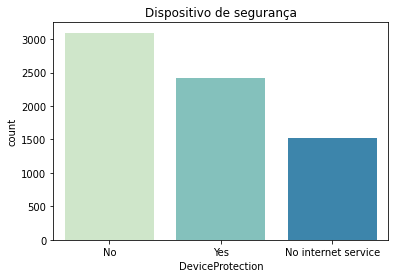

In [19]:
print(df.DeviceProtection.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('DeviceProtection', data=df, ax=ax, palette="GnBu")
ax.set_title('Dispositivo de segurança')

plt.show()

No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: TechSupport, dtype: float64


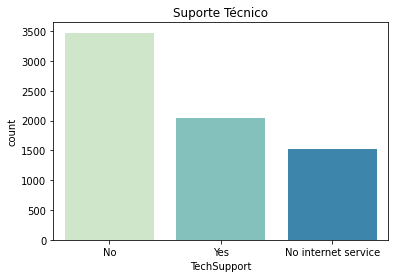

In [20]:
print(df.TechSupport.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('TechSupport', data=df, ax=ax, palette="GnBu")
ax.set_title('Suporte Técnico')

plt.show()

No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: StreamingTV, dtype: float64


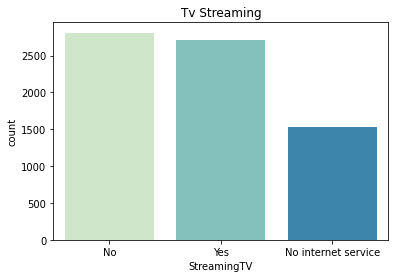

In [21]:
print(df.StreamingTV.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('StreamingTV', data=df, ax=ax, palette="GnBu")
ax.set_title('Tv Streaming')

plt.show()

No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: StreamingMovies, dtype: float64


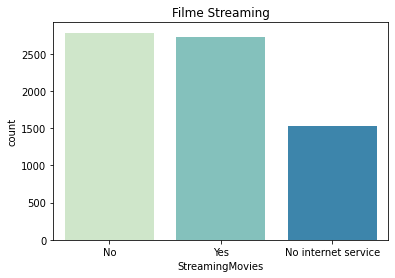

In [22]:
print(df.StreamingMovies.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('StreamingMovies', data=df, ax=ax, palette="GnBu")
ax.set_title('Filme Streaming')

plt.show()

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Contract, dtype: float64


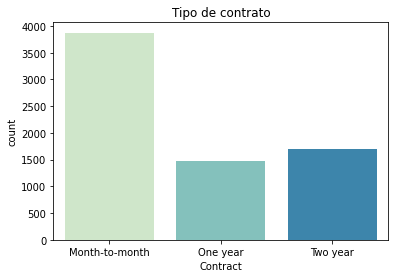

In [23]:
print(df.Contract.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('Contract', data=df, ax=ax, palette="GnBu")
ax.set_title('Tipo de contrato')

plt.show()

Yes    0.592219
No     0.407781
Name: PaperlessBilling, dtype: float64


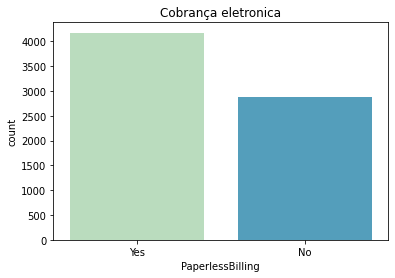

In [24]:
print(df.PaperlessBilling.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('PaperlessBilling', data=df, ax=ax, palette="GnBu")
ax.set_title('Cobrança eletronica')

plt.show()

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: PaymentMethod, dtype: float64


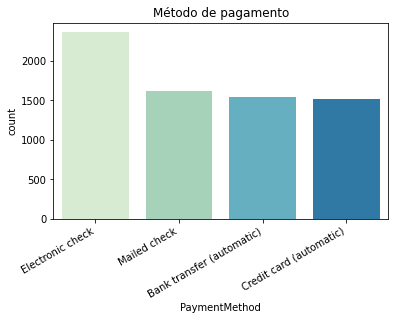

In [25]:
print(df.PaymentMethod.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('PaymentMethod', data=df, ax=ax, palette="GnBu")
ax.set_title('Método de pagamento')
fig.autofmt_xdate()

plt.show()

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


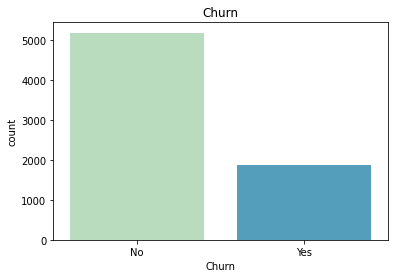

In [26]:
print(df.Churn.value_counts() / df.shape[0])

fig, ax = plt.subplots()
sns.countplot('Churn', data=df, ax=ax, palette="GnBu")
ax.set_title('Churn')


plt.show()

In [27]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


# Primeiros insights

O analisando brevemente podemos observar que:

* 70% dos clientes não possuem dependentes;
* 90% tem linha telefonica;
* 21,97% não possuem serviço de internet;
* Existem 3 tipos de contrato mesal 55,02%, anual 20,91%, e bianual 24,07%.
* Grande parte das variavéis são categóricas, porém algums contém por exemplo No e No Phone service, com isso sabemos que podemos transformar variável binaria;
* O dataset apresenta não haver outliers.

Aqui também é possível notar a variável ***`Churn`*** que será nosso alvo no decorrer do projeto, Nele vemos que 26,54% dos clientes se evadiram.

Podemos refoçar que não há outliers por meio de um boxplot das colunas `MonthlyCharges` e `TotalCharges`

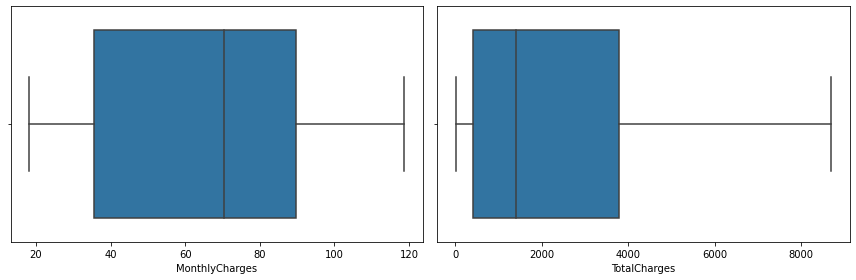

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean["MonthlyCharges"], ax=ax[0])
sns.boxplot(df_clean["TotalCharges"], ax=ax[1])
plt.tight_layout()

O thershold padrão não acusou nenhum plot fora dos limites superior e infeior

A variável `tenure` é o tempo que o cliente permanece com o serviço, pode ser um idicativo de fidelidade.

Por falta de informação vamos assumir que o tempo adotado é "mês".

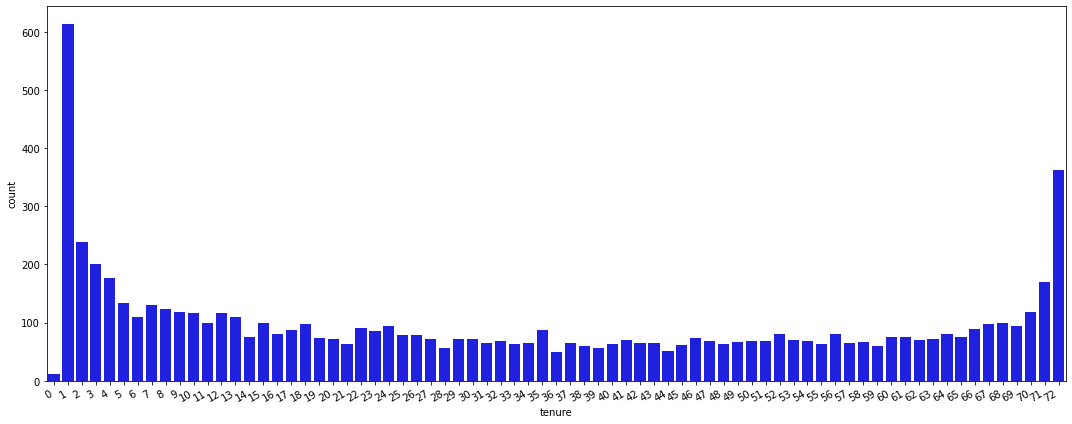

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(df['tenure'], color="blue")
fig.autofmt_xdate()
plt.tight_layout()

# Transformando Dados 

Grande parte das entradas no *dataset* são de variáveis categóricas binárias, com isso para melhores resultados na construção de um modelo preditivo vamos converter para númericas, onde No e No service seram atribuidas 0 e yes será 1. 

Nesta parte do projeto fizemos um pré-processamento afim de começar a construir um modelo base.

Para as variaveis com mais de 3 categorias utilizamos um método de transfomação conhecida por variável [Dummy](https://medium.com/data-hackers/vari%C3%A1veis-dummy-o-que-%C3%A9-quando-usar-e-como-usar-78de66cfcca9). Para as com apenas duas foi utilizando o `LabelEncoder`. Salientando que nessa etapa utilizaremos também a variavel alvo **Churn**. Com isso feito vamos a seguir, separar nossos dados de treino e teste para dar início a construção do nosso modelo de Machine Learning. 

In [30]:
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

df_proc = df_clean.copy()

le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

df_proc = pd.get_dummies(df_proc, columns=cat_var)

df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [31]:
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y)

Com os dados devidamente separados vamos partir para a construção do modelo, nessa etapa não vamos feito nenhum ajuste de hiperparâmetro nem balaceamento, o intuito é avaliar pelo método de *cross-validation*. Por motivo de praticidade criaremos uma função `val_model`, e a métrica usada para avaliação será o recall. 

### Por que ultilizar Recall?

A métrica Recall é utilizada para indicar a relação entre as previsões positivas realizadas corretamente e todas as previsões que realmente são positivas (True Positives e False Negatives). Como o principal objetivo do projeto é prever possíveis perdas de receita proveniente de evasão de clientes. Sendo assim ela é um bom indicativo para aviliar o modelo.

In [32]:
def val_model(X, y, clf, quite=False):
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print(f"Recall: {scores.mean():.2f} (+/- {scores.std():.2f})")

    return scores.mean()

A priori vamos usar o modelo de regressão logistica apenas como um ponto de partida.

In [40]:
rf = LogisticRegression()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.53 (+/- 0.03)


A partir do nosso baseline acima podemos avaliar se os ajustes melhoram o pioram nosso modelo.

A primeira alteração que será feita é um balanceamento dos dados, seguido da padronização dos dados. A técnica utilizada é o *Under Sampling*, após o teste de desempenho das outras.

In [41]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Aplicando *Cross-validation*, vamos selecionar o modelo que obteve o melhor desempenho e otimizar seus hiperparâmentros. Os modelos usados serão os seguintes:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Logistic Regression
* XGB Classifier
* LightGBM

In [42]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()


model = []
recall = []
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.762590
DecisionTreeClassifier,0.661151
SGDClassifier,0.751079
SVC,0.787770
LogisticRegression,0.801439
XGBClassifier,0.794245
LGBMClassifier,0.758993


Acima observamos que o LogisticRegression e XGBClassifier tem particamente um empate, no entanto para seguir com o projeto dada as maiores possibilidade de tuning nos hiperparâmetros adotaremos o XGBoost como nosso modelo.

# Otimização dos Hiperparâmentros.

O objetivo será encontrar os melhores tuning de parâmentros, a seguir vamos definir uma taxa de aprendizado e números de estimadores. Utilizando a técnica *Grid Search* vamos procura os melhore parametros para otimização. Iniciaremos com o `learning_rate=0.1`

In [43]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
    'n_estimators': range(0,1000,50)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"melhor: {grid_result.best_score_} para {grid_result.best_params_}")

melhor: 0.8035971223021583 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca dos parâmetros `max_depth` e `min_child_weight`

In [44]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
    'learning_rate':[0.001, 0.01, 0.1, 1]
}
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

print(f"melhor: {grid_result.best_score_} para {grid_result.best_params_}")

melhor: 0.8812949640287769 para {'learning_rate': 0.001}


Fato é que com uma taxa de aprendizado menor o desempenho do modelo melhorou, se for levado em conta apenas o `recall`.



# Finalizando 

Agora com os parametros ajustados vamos treinar o modelo final e plotar a matriz de confusão.

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      1282
           1       0.50      0.86      0.64       479

    accuracy                           0.73      1761
   macro avg       0.72      0.77      0.71      1761
weighted avg       0.81      0.73      0.75      1761

AUC: 0.7712


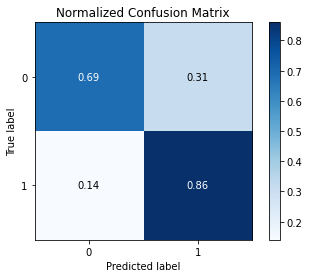

In [45]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_pred):.4f}")

plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

# Conclusão.

Para este projeto assumimos que nossa métrica de maior relevancia é *recall*. Sendo assim conseguimos obter uma taxa de acerto de possiveis cancelamento de 86%, com isso podendo tomar decisões estrategicas afim de reter esse clientes e consequentemente reduzindo o **Churn rate**, porporcionando uma receita mais estável.